In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import pandas as pd

## !ln -s /usr/lib/python3/dist-packages/graph_tool\
## $HOME/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool
import graph_tool.all as gt
import hdfgraph
import leg_joint as lj

/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1340: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [4]:
%matplotlib inline

#  Representing a dynamical 3D+t graph with pandas and vispy

## Introduction



In [5]:
h5_path = '/media/data/Simulations/0001_2014-05-24T09_04_38/eptm_0001_2014-05-24T09_04_38.h5'
#h5_path = '/home/guillaume/Notebooks/small/eptm_small_2014-09-15T16_45_46.h5'

In [6]:
vertices_df = hdfgraph.vertices_time_slice(h5_path, 4, 5)
print(vertices_df.index.get_level_values('stamp').unique())
print(vertices_df.zeds.min())
edges_df = hdfgraph.edges_time_slice(h5_path, 4, 5)
print(edges_df.index.get_level_values('stamp').unique())


[4]
-48.94449105155271
[4]


In [7]:
jes = edges_df[edges_df['is_junction_edge'] == 1]

In [8]:
%pdb

Automatic pdb calling has been turned ON


In [9]:
def slice_data(vertices_df, edges_df, v_bounds={}):

    for col, (v_min, v_max) in v_bounds.items():
        vertices_df = vertices_df[vertices_df[col] >= v_min]
        vertices_df = vertices_df[vertices_df[col] <= v_max]
    vertex_index = set(vertices_df.index.get_level_values('vertex_index'))

    src_index = set(edges_df.index.get_level_values('source'))
    trgt_index = set(edges_df.index.get_level_values('target'))
    srcs = src_index.intersection(vertex_index)
    trgts = trgt_index.intersection(vertex_index)
    edges_df['keep'] = True
    keep = edges_df.groupby(level='source', group_keys=False).apply(select_idx_, 'source', srcs)
    edges_df = edges_df[keep.values]
    keep = edges_df.groupby(level='target', group_keys=False).apply(select_idx_, 'target', trgts)
    edges_df = edges_df[keep.values]
    return vertices_df, edges_df


def select_idx_(df, idx_name, valids):
    idx = df.index.get_level_values(idx_name)[0]
    keep = df['keep'].copy()
    keep.loc[:] = True
    if idx not in valids:
        keep.loc[:] = False
    return keep

def load_vertices(fname, start_stamp, stop_stamp, cols=None):

    vertices = hdfgraph.vertices_time_slice(fname, start_stamp, stop_stamp)
    if cols is not None:
        vertices = vertices[cols]
    return vertices.swaplevel(0, 1).sortlevel()

def load_edges(fname, start_stamp, stop_stamp, cols=None):

    edges = hdfgraph.edges_time_slice(fname, start_stamp, stop_stamp)
    if cols is not None:
        edges = edges[cols]
    return edges.swaplevel(0,1).swaplevel(1,2).sortlevel()


In [10]:
%pdb

Automatic pdb calling has been turned OFF


In [11]:
start_stamp, stop_stamp = 4, 5 
vertices_df = load_vertices(h5_path, start_stamp, stop_stamp)
edges_df = load_edges(h5_path, start_stamp, stop_stamp)
v_bounds = {}#{'zeds': (-8, 8), 'thetas': (-np.pi/6, np.pi/6)}

if len(v_bounds):
    vertices_df, edges_df = slice_data(vertices_df, edges_df, v_bounds)


In [12]:
vertices_df.shape


(5202, 28)

In [13]:
src_index = set(edges_df.index.get_level_values('source'))
trgt_index = set(edges_df.index.get_level_values('target'))

vertex_index = set(vertices_df.index.get_level_values('vertex_index'))


In [14]:
vertices_df.columns
edges_df.columns

Index(['at_boundary', 'dixs', 'drhos', 'dsigmas', 'dthetas', 'dwys', 'dzeds',
       'edge_lengths', 'is_active_edge', 'is_ctoj_edge', 'is_junction_edge',
       'is_local_edge', 'is_new_edge', 'line_tensions', 'u_dixs', 'u_drhos',
       'u_dsigmas', 'u_dwys', 'u_dzeds'],
      dtype='object')

In [15]:
#cells_df = vertices_df[vertices_df['is_cell_vert']==1]#
cells_df = vertices_df[vertices_df['is_cell_vert'] == 1].sortlevel()
jvs_df = vertices_df[vertices_df['is_cell_vert'] == 0].sortlevel()
jes_df = edges_df[edges_df['is_junction_edge'] == 1].sortlevel()
ctojs_df = edges_df[edges_df['is_junction_edge'] == 0].sortlevel()


In [16]:
def out_neighbours(cell_idx, ctojs_df, jvs_df):
    '''returns the chunk of the vertices dataframe containing the data
    for the cell's neighboursd
    '''
    neighbs_idx = ctojs_df.xs(cell_idx, level='source').index.set_names(['vertex_index', 'stamp'])
    return neighbs_idx, jvs_df.loc[neighbs_idx]


In [17]:

for cell_idx, cell_df in cells_df.groupby(level='vertex_index'):
    t0 = cell_df.index.get_level_values('stamp')[0]
    coords = ['ixs', 'wys', 'zeds']
    x, y, z = cell_df[coords].iloc[0]
    neighbs_idx, neighbs_jvs = out_neighbours(cell_idx, ctojs_df, jvs_df)
    
    j_xx, j_yy, j_zz = neighbs_jvs[coords].values.T

    print(j_xx, j_yy, j_zz)
    break

    

[ 26.6937399   26.99722709  26.29604362] [-0.38740591  1.99460153  4.35428995] [-47.05046535 -46.38536802 -47.33699084]


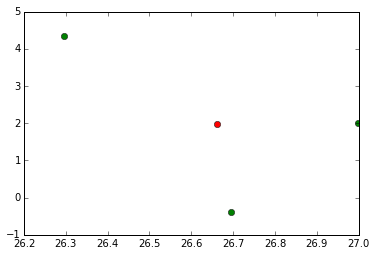

In [18]:

import matplotlib.pyplot as plt

plt.plot(j_xx, j_yy, 'go')
plt.plot(x, y, 'ro')


In [19]:
import numpy as np
import vispy
import vispy.gloo as gloo
from vispy import app
from vispy.util.transforms import perspective, translate, rotate
app.use_app('PyQt4');

In [20]:
a_position = np.array(jvs_df[['ixs', 'wys', 'zeds']])
a_position /= np.abs(a_position).max()
a_id = np.array(jvs_df.index.get_level_values('vertex_index'))
a_id = np.sort(a_id, axis=0).astype(np.float32)

In [21]:
a_id.dtype


dtype('float32')

In [22]:
VERT_SHADER = """
uniform mat4 u_model;
uniform mat4 u_view;
uniform mat4 u_projection;
attribute vec3 a_position;
attribute float a_id;
varying float v_id;
void main (void) {
    v_id = a_id;
    gl_Position = u_projection * u_view * u_model * vec4(a_position,1.0);
}
"""

FRAG_SHADER = """
varying float v_id;
void main()
{
    float f = fract(v_id);
    // The second useless test is needed on OSX 10.8 (fuck)
    if( (f > 0.0001) && (f < .9999) )
        discard;
    else
        gl_FragColor = vec4(0,0,0,1);
}
"""

In [23]:
class Canvas(app.Canvas):
    def on_initialize(self, event):
        self.program = gloo.Program(VERT_SHADER, FRAG_SHADER)

        # Set uniform and attribute
        self.program['a_id'] = gloo.VertexBuffer(a_id)
        self.program['a_position'] = gloo.VertexBuffer(a_position)

        self.view = np.eye(4, dtype=np.float32)
        self.model = np.eye(4, dtype=np.float32)
        self.projection = np.eye(4, dtype=np.float32)

        self.translate = 5
        translate(self.view, 0, 0, -self.translate)
        self.program['u_model'] = self.model
        self.program['u_view'] = self.view

        self.theta = 0
        self.phi = 0

        gloo.set_clear_color('white')
        gloo.set_state('translucent')
        
        self.timer = app.Timer('auto', connect=self.on_timer, 
                              start=True)

    def on_timer(self, event):
        self.theta += .0
        self.phi += .0
        self.model = np.eye(4, dtype=np.float32)
        rotate(self.model, self.theta, 0, 0, 1)
        rotate(self.model, self.phi, 0, 1, 0)
        self.program['u_model'] = self.model
        self.update()

    def on_resize(self, event):
        width, height = event.size
        gloo.set_viewport(0, 0, width, height)
        self.projection = perspective(45.0, width / float(height), 1.0, 1000.0)
        self.program['u_projection'] = self.projection
        
    def on_mouse_wheel(self, event):
        self.translate += event.delta[1]
        self.translate = max(2, self.translate)
        self.view = np.eye(4, dtype=np.float32)
        translate(self.view, 0, 0, -self.translate)
        self.program['u_view'] = self.view
        self.update()

    def on_draw(self, event):
        gloo.clear()
        self.program.draw('line')

In [24]:
c = Canvas(size=(600, 600))
c.show()

  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/traitlets/config/application.py", line 592, in launch_instance
    app.start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/kernelapp.py", line 389, in start
    ioloop.IOLoop.instance().start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, e

In [ ]:
/media/data/Simulations/0001_2014-05-24T09_04_38/eptm_0001_2014-05-24T09_04_38.h5

In [1]:
import itertools
import numpy as np
import sys

from vispy import app, scene
from vispy.color import colormaps
from vispy.visuals.transforms import STTransform
from vispy.ext.six import next

colormaps = itertools.cycle(colormaps)

# vertex positions of data to draw
N = 200
pos = np.zeros((N, 2), dtype=np.float32)
pos[:, 0] = np.linspace(10, 390, N)
pos[:, 1] = np.random.normal(size=N, scale=20, loc=0)


canvas = scene.SceneCanvas(keys='interactive', size=(400, 200), show=True)

# Create a visual that updates the line with different colormaps
color = next(colormaps)
line = scene.Line(pos=pos, color=color, mode='gl')
line.transform = STTransform(translate=[0, 140])
line.parent = canvas.central_widget

text = scene.Text(color, bold=True, font_size=24, color='w',
                  pos=(200, 40), parent=canvas.central_widget)


def on_timer(event):
    global colormaps, line, text, pos
    color = next(colormaps)
    line.set_data(pos=pos, color=color)
    text.text = color
    
timer = app.Timer(2.0, connect=on_timer, start=True)


if __name__ == '__main__':
    if sys.flags.interactive != 1:
        canvas.app.run()


  File "<string>", line 1, in <module>
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/IPython/kernel/zmq/kernelapp.py", line 469, in main
    app.start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/IPython/kernel/zmq/kernelapp.py", line 459, in start
    ioloop.IOLoop.instance().start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/zmq/eventloop/ioloop.py", line 151, in start
    super(ZMQIOLoop, self).start()
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/tornado/ioloop.py", line 837, in start
    handler_func(fd_obj, events)
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/zmq/eventloop/zmqstream.py", line 433, in _handle_events
    self._handle_recv()
  File "/home/guillaume/anaconda/envs/pyth